<a href="https://colab.research.google.com/github/JonathanBergen/cuda-press/blob/main/take_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Compression using K-means, parallelized with pyCuda

In [ ]:
# Import modules
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import time
import numpy as np

In [ ]:
# Read an image from a file
fileName = input("Enter the file name: ")

Enter the file name: dietrich.jpg


In [ ]:
# Load the image into an array
image = plt.imread(fileName)
print(image.shape)

(4032, 3024, 3)


In [ ]:
# Display RGB image on a 3D plot, with the x, y, and z axis representing the red, green, and blue channels respectively

# Extract R, G, B channels
R = image[:, :, 0]
G = image[:, :, 1]
B = image[:, :, 2]

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot RGB values as scatter points
ax.scatter(R.flatten(), G.flatten(), B.flatten(), c=image.reshape((-1,3))/255.0, marker='o')

# Set axis labels
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

# Show plot
plt.show()

KeyboardInterrupt: ignored

In [ ]:
# Get number of centroids (this is the value of k)
while True:
    n_centroids = input("Enter number of centroids: ")
    try:
        n_centroids = int(n_centroids)
        print(f"Proceeding with k = {n_centroids}")
        break
    except ValueError:
        print("Invalid input. Please enter an integer.")

Enter number of centroids: 10
Proceeding with k = 10


Number of pixels: 12192768
Selecting 10 random data points to serve as initial centroids
Selected pixels: [[1703, 2971], [2134, 726], [1051, 289], [2219, 2466], [2929, 426], [596, 413], [278, 118], [1583, 2100], [1527, 703], [1080, 811]]
Centroids: [array([119, 128, 133], dtype=uint8), array([249, 211, 128], dtype=uint8), array([118, 143, 173], dtype=uint8), array([88, 41,  0], dtype=uint8), array([50, 48, 36], dtype=uint8), array([ 93, 119, 154], dtype=uint8), array([ 76, 102, 137], dtype=uint8), array([126, 152, 175], dtype=uint8), array([196, 196, 186], dtype=uint8), array([121, 146, 176], dtype=uint8)]


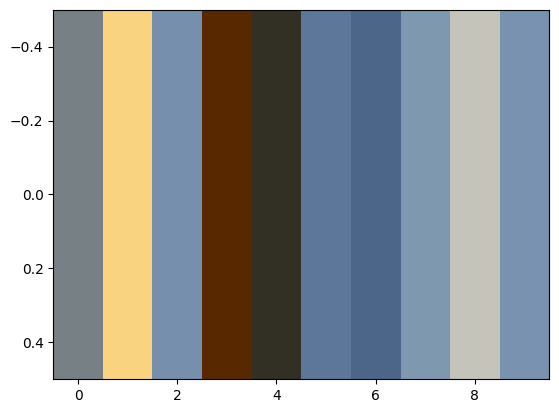

In [ ]:
# Assign random centroids
n_rows = image.shape[0]
n_columns = image.shape[1]
n_pixels = n_rows * n_columns
print("Number of pixels: " + str(n_pixels))
print(f"Selecting {n_centroids} random data points to serve as initial centroids")

# Using the .sample function eliminates duplicate choices
selections = random.sample(range(n_pixels), n_centroids)
selections = [[sel // n_rows, sel % n_columns] for sel in selections]
print("Selected pixels: " + str(selections))

# Create a list of centroids
centroids = []
for i,j in selections:
    centroids.append(image[i][j])
print("Centroids: " + str(centroids))

color_array = np.array([np.array(centroids, dtype=np.uint8)])

# Display the color array as a matplotlib graph
fig, ax = plt.subplots()
ax.imshow(color_array, aspect='auto')
plt.show()

In [ ]:
# A function to calculate the distance between a point and a centroid in three dimensions
# def distance(point, centroid):
#     return ((point.r - centroid.r) ** 2 + (point.g - centroid.g) ** 2 + (point.b - centroid.b) ** 2)

In [ ]:
# One-time PyCuda installs
# !wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
# !sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
# !wget https://developer.download.nvidia.com/compute/cuda/11.2.0/local_installers/cuda-repo-ubuntu1804-11-2-local_11.2.0-460.27.04-1_amd64.deb
# !sudo dpkg -i cuda-repo-ubuntu1804-11-2-local_11.2.0-460.27.04-1_amd64.deb
# !sudo apt-key add /var/cuda-repo-ubuntu1804-11-2-local/7fa2af80.pub
# !sudo apt-get update
# !sudo apt-get -y install cuda
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Determine the best grid ad block dimensions
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.tools import DeviceData

# Create a PyCUDA context for the current device.
ctx = cuda.Device(0).make_context()

# Get the stats for the current device.
device_data = DeviceData()
max_threads_per_block = device_data.max_threads
warp_size = device_data.warp_size
memory_per_block = device_data.shared_memory

# Print the stats.
print(f"Max threads per block: {max_threads_per_block}")
print(f"Warp size: {warp_size}")
print(f"Device memory: {memory_per_block}")

# Release the PyCUDA context.
ctx.pop()

# Define block dimensions
block_dim = (warp_size, warp_size, 1)

# Calculate grid dimensions
grid_dim_x = int((n_columns + block_dim[0] - 1) / block_dim[0])
grid_dim_y = int((n_rows + block_dim[1] - 1) / block_dim[1])
grid_dim_z = 1
grid_dim = (grid_dim_x, grid_dim_y, grid_dim_z)

thread_dim_x = grid_dim_x * block_dim[0]
thread_dim_y = grid_dim_y * block_dim[1]
thread_dim_2d = thread_dim_x * thread_dim_y

print(f"Grid dim: {grid_dim}")
print(f"Block dim: {block_dim}")
print(f"Total threads allocated: {thread_dim_x} x {thread_dim_y} = {thread_dim_2d}")
print(f"Threads utilized: {n_pixels / thread_dim_2d * 100}%")

Max threads per block: 1024
Warp size: 32
Device memory: 49152
Grid dim: (95, 126, 1)
Block dim: (32, 32, 1)
Total threads allocated: 3040 x 4032 = 12257280
Threads utilized: 99.47368421052632%


In [ ]:
# Copy the image data to the GPU

import pycuda.gpuarray as gpuarray

im_gpu = gpuarray.to_gpu(image)

ModuleNotFoundError: ignored

In [ ]:
# Loop through the iterations

max_iterations = input("Enter the maximum number of iterations: ")

for i in range(max_iterations):
    # Assign each point to the closest centroid
    for point in points:
        # Calculate the distance between the point and the centroid
        # Assign the point to the closest centroid
        # Update the cluster assignment of the point
        pass

    # Update the centroids
    for centroid in centroids:
        # Calculate the mean of the points assigned to the centroid
        # Update the centroid to the mean of the points assigned to it
        pass


In [ ]:
# Display the clustered image on a 3D plot

In [ ]:
# Display the final image